# Exploratory Data Analysis of Epicurious Scrape in a JSON file

This is an idealized workflow for Aaron Chen in looking at data science problems. It likely isn't the best path, nor has he rigidly applied or stuck to this ideal, but he wishes that he worked this way more frequently.

## Purpose: This notebook will do some clustering and classification on the recipes missing cuisine labels. Make this fast and see what we can get. Then move on to:

1. Fixing Render
2. Creating login system to store searches and preferences
3. Fixing the filtering
4. Working on scrapers
5. Working on the database

### Author: Aaron Chen


---

### If needed, run shell commands here

In [1]:
# !python -m spacy download en_core_web_sm
# !python -c "import tkinter"


---

## External Resources

List out references or documentation that has helped you with this notebook

### Code
Regex Checker: https://regex101.com/

#### Scikit-learn
1. https://scikit-learn.org/stable/modules/decomposition.html#latent-dirichlet-allocation-lda
2. 

### Data

For this notebook, the data is stored in the repo base folder/data/raw

### Process

Are there steps or tutorials you are following? Those are things I try to list in Process

___

## Import necessary libraries

In [2]:
# from bokeh.plotting import figure, output_file, save, show
# from bokeh.io import output_notebook
import hdbscan
from joblib import dump, load
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import optuna
import pandas as pd
from scipy.spatial.distance import euclidean
import seaborn as sns
from sklearn.decomposition import NMF
from sklearn.model_selection import train_test_split


---

## Define helper functions

My workflow is to try things with code cells, then when the code cells get messy and repetitive, to convert into helper functions that can be called.

When the helper functions are getting used a lot, it is usually better to convert them to scripts or classes that can be called/instantiated

In [3]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1: -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()


### Import local script

I started grouping this in with importing libraries, but putting them at the bottom of the list

In [4]:
import project_path

import src.dataframe_preprocessor as dfpp
import src.nlp_processor as nlp_proc
import src.plotter as ILoveMyKeyboard
import src.transformers as skt

%matplotlib inline


/home/awchen/Repos/Projects/MeaLeon/.venv/lib/python3.8/site-packages/spacy/util.py:837: UserWarning: [W095] Model 'en_core_web_sm' (3.2.0) was trained with spaCy v3.2 and may not be 100% compatible with the current version (3.3.1). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


---

## Define global variables 
### Remember to refactor these out, not ideal

In [5]:
# output_notebook()


---

## Running Commentary

1. 

### To Do

1. Can do another dimension reduction to make a 2D visualization after attaching HDBSCAN labels to the original data

Or

2. ~~See how the HDBSCAN labels "map" to cuisine labels~~

   1. ~~Go back, reattach index labels to data so that you can compare the original recipes with the HDBSCAN labels~~

3. ~~Predict HDBSCAN labels for the recipes that are missing cuisines and see where they line up (noise, etc)~~

   1. ~~But also maybe compared to cuisine labels...depending on how many "noisy" recipes there are, this might not be very productive, but see how this looks~~
   
4. Could this new HDBSCAN label used instead of a hard mapped cuisine label? What would the results look like?

   1. Gets a little tricky if recipes map to noise
   
   2. This involves a refactor of MeaLeon's webapp (which is overdue)
   
5. Can still do 2D visualization to have something up (back to item 1)

   1. Mix in the probability to impact "density" of color (like the HDBSCAN plot examples...but in Bokeh)

---

## Importing and viewing the data as a dataframe

In [6]:
raw_data_path = '../../data/recipes-en-201706/epicurious-recipes_m2.json'

joblib_basepath = '../../joblib/2022.08.23/'

cv_path = joblib_basepath + 'countvec.joblib'
tfidf_path = joblib_basepath + 'tfidf.joblib'
full_df_path = joblib_basepath + 'recipes_with_cv.joblib'
reduced_df_path = joblib_basepath + 'reduced_df.joblib'
rfc_path = joblib_basepath + 'rfc_clf.joblib'
X_path = joblib_basepath + 'X.joblib'
y_path = joblib_basepath + 'y.joblib'
truncSVD_path = joblib_basepath + 'truncSVD.joblib'
truncSVD_transformed_path = joblib_basepath + 'truncSVD_transformed.joblib'
svd_numpy_path = joblib_basepath + 'SVD_numpy.joblib'
to_plot_path = joblib_basepath + 'to_plot.joblib'
tsne_path = joblib_basepath + 'tsne.joblib'
tsne_vis_path = joblib_basepath + 'tsne_vis.joblib'
kmeans_path = joblib_basepath + 'kmeans.joblib'
nmf_path = joblib_basepath + 'nmf.joblib'  # nmf
X_nmf_path = joblib_basepath + 'X_nmf.joblib'  # X_nmf
hdbscan_model_path = joblib_basepath + 'hdbscan.joblib'  # hdbscanner
train_high_val_hdbscan_labels_path = joblib_basepath + \
    'train_high_val_hdbscan.joblib'  # train_high_val_hdbscan_labels
test_high_val_hdbscan_labels_path = joblib_basepath + \
    'test_high_val_hdbscan.joblib'  # test_high_val_hdbscan_labels


In [7]:
cv = load(cv_path)
tfidf = load(tfidf_path)
recipes_with_cv = load(full_df_path)
recipes_with_cv.set_index('id', inplace=True, drop=True)
reduced_df = load(reduced_df_path)
reduced_df.set_index('id', inplace=True, drop=True)
rfc_clf = load(rfc_path)
X = load(X_path)
y = load(y_path)
nmf = load(nmf_path)
X_nmf = load(X_nmf_path)
X_nmf_df = pd.DataFrame(data=X_nmf, index=X.index)
hdbscanner = load(hdbscan_model_path)
train_high_val_labels = load(train_high_val_hdbscan_labels_path)
test_high_val_labels = load(test_high_val_hdbscan_labels_path)


In [8]:
recipes_with_cv


,dek,hed,aggregateRating,ingredients,prepSteps,reviewsCount,willMakeAgainPct,cuisine_name,photo_filename,photo_credit,...,zest pith,zest vegetable,zinfandel,ziti,zucchini,zucchini blossom,zucchini crookneck,zucchini squash,árbol,árbol pepper
id,,,,,,,,,,,,,,,,,,,,,
54a2b6b019925f464b373351,How does fried chicken achieve No. 1 status? B...,Pickle-Brined Fried Chicken,3.11,"[1 tablespoons yellow mustard seeds, 1 tablesp...",[Toast mustard and coriander seeds in a dry me...,7,100,Missing Cuisine,51247610_fried-chicken_1x1.jpg,Michael Graydon and Nikole Herriott,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54a408a019925f464b3733bc,Spinaci all'Ebraica,Spinach Jewish Style,3.22,"[3 pounds small-leaved bulk spinach, Salt, 1/2...",[Remove the stems and roots from the spinach. ...,5,80,Italian,EP_12162015_placeholders_rustic.jpg,"Photo by Chelsea Kyle, Prop Styling by Anna St...",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54a408a26529d92b2c003631,"This majestic, moist, and richly spiced honey ...",New Year’s Honey Cake,3.62,"[3 1/2 cups all-purpose flour, 1 tablespoon ba...",[I like this cake best baked in a 9-inch angel...,105,88,Kosher,EP_09022015_honeycake-2.jpg,"Photo by Chelsea Kyle, Food Styling by Anna St...",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54a408a66529d92b2c003638,The idea for this sandwich came to me when my ...,The B.L.A.Bagel with Lox and Avocado,4.00,"[1 small ripe avocado, preferably Hass (see No...","[A short time before serving, mash avocado and...",7,100,Kosher,EP_12162015_placeholders_casual.jpg,"Photo by Chelsea Kyle, Prop Styling by Rhoda B...",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54a408a719925f464b3733cc,"In 1930, Simon Agranat, the chief justice of t...",Shakshuka a la Doktor Shakshuka,2.71,"[2 pounds fresh tomatoes, unpeeled and cut in ...","[1. Place the tomatoes, garlic, salt, paprika,...",7,83,Kosher,EP_12162015_placeholders_formal.jpg,"Photo by Chelsea Kyle, Prop Styling by Rhoda B...",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59541a31bff3052847ae2107,Buttering the bread before you waffle it ensur...,Waffled Ham and Cheese Melt with Maple Butter,0.00,"[1 tablespoon unsalted butter, at room tempera...","[Preheat the waffle iron on low., Spread a thi...",0,0,Missing Cuisine,waffle-ham-and-cheese-melt-062817.jpg,"Photo by Maes Studio, Inc.",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5954233ad52ca90dc28200e7,"Spread this easy compound butter on waffles, p...",Maple Butter,0.00,"[8 tablespoons (1 stick) salted butter, at roo...",[Combine the ingredients in a medium-size bowl...,0,0,Missing Cuisine,EP_12162015_placeholders_bright.jpg,"Photo by Chelsea Kyle, Prop Styling by Anna St...",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
595424c2109c972493636f83,Leftover mac and cheese is not exactly one of ...,Waffled Macaroni and Cheese,0.00,"[3 tablespoons unsalted butter, plus more for ...",[Preheat the oven to 375°F. Butter a 9x5-inch ...,0,0,Missing Cuisine,waffle-mac-n-cheese-062816.jpg,"Photo by Maes Studio, Inc.",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
nmf = NMF(
    n_components=10,
    random_state=1,
    init='nndsvd',
    beta_loss="frobenius",
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=1,
).fit(X)


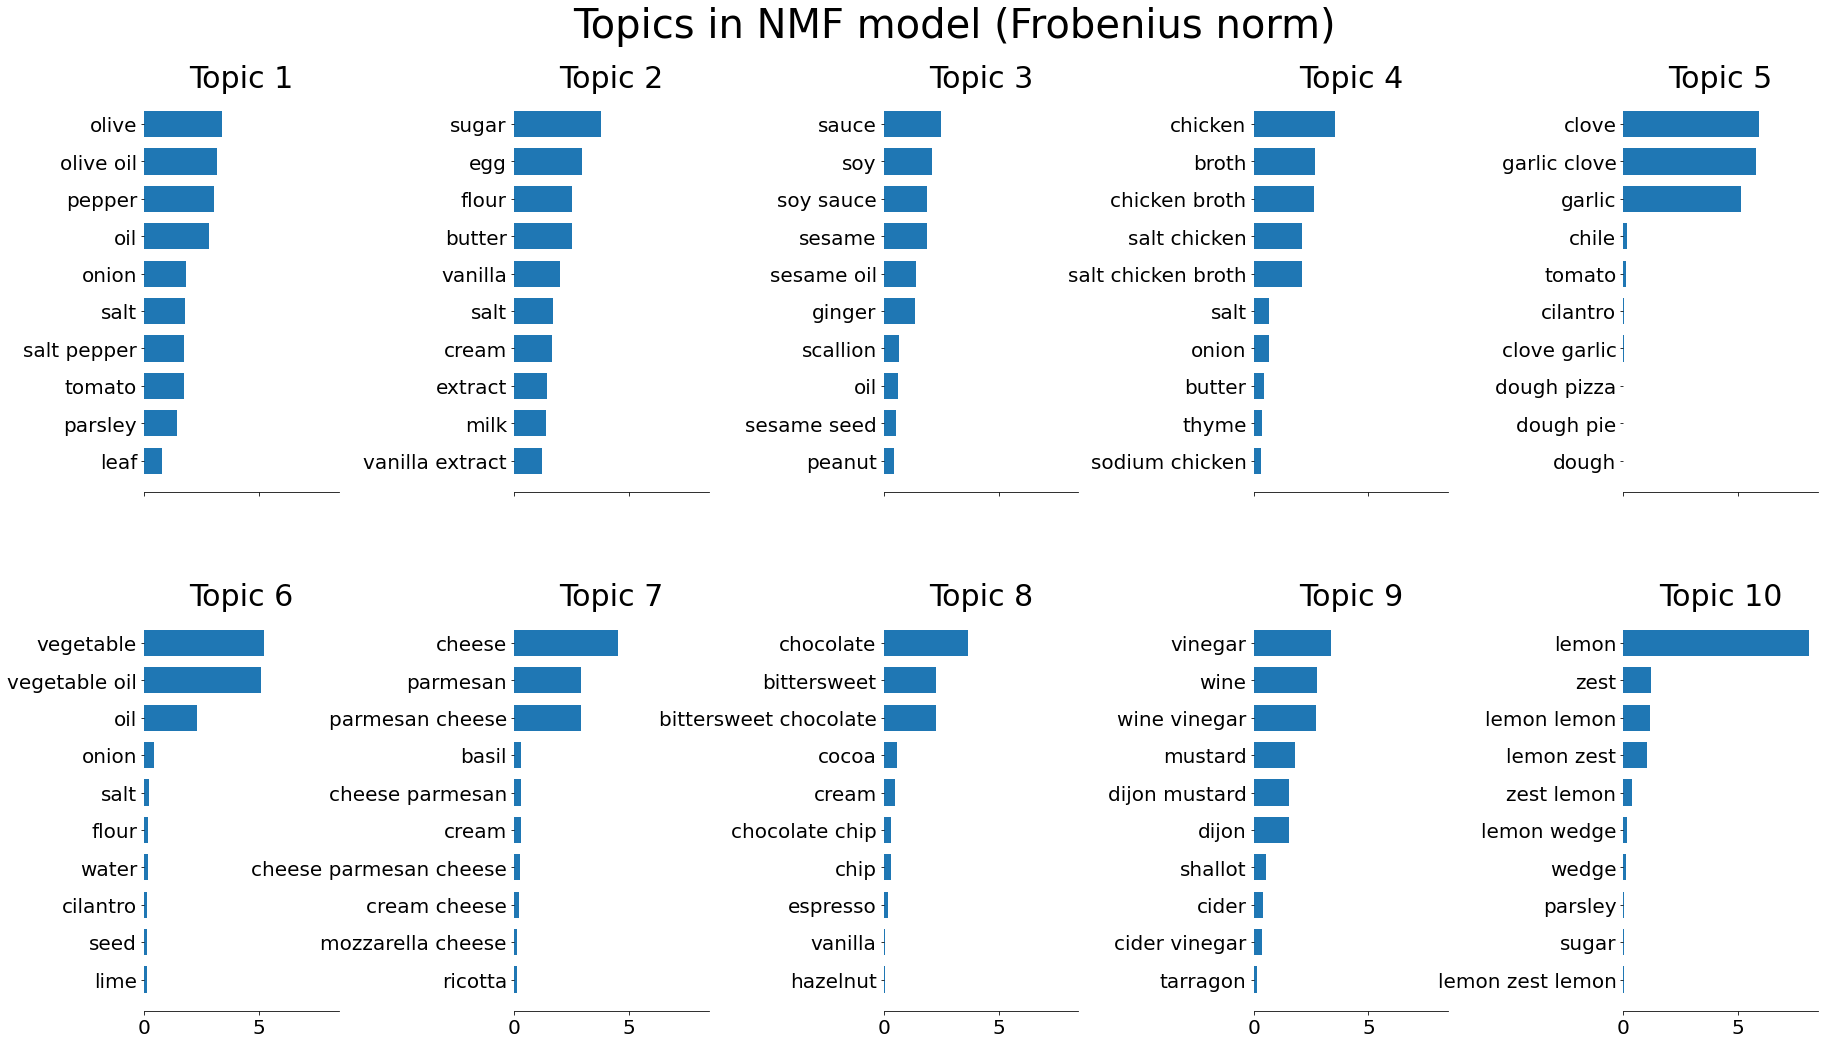

In [10]:
n_samples = 2000
n_features = 1000
n_components = 10
n_top_words = 10
batch_size = 128
init = "nndsvda"

feature_names = cv.get_feature_names_out()
plot_top_words(
    nmf, feature_names, n_top_words, "Topics in NMF model (Frobenius norm)"
)


Hmm, based on the topic model word distribution, the NMF model may need some tweaking

In [11]:
# study.best_trial.params

# {'min_cluster_size': 14,
#  'min_samples': 57,
#  'cluster_selection_epsilon': 0.20026550423686748}


In [12]:
# this gives a tuple of arrays with the HDBSCAN label and the probability of being that label
hdbscan_predicted_labels = hdbscan.approximate_predict(hdbscanner, X_nmf_df)
hdbscan_predicted_labels


(array([-1, -1, -1, ..., -1, -1,  7], dtype=int32),
 array([0., 0., 0., ..., 0., 0., 1.]))

In [13]:
hdbscan_predicted_labels[1][200:250]


array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.86876576, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       1.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 1.        ,
       0.        , 0.        , 1.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 1.        , 0.        ])

<AxesSubplot: ylabel='$\\lambda$ value'>

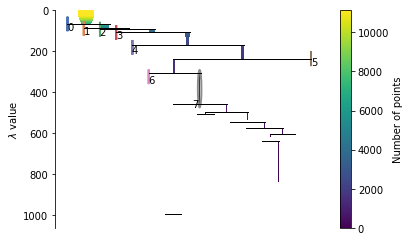

In [14]:
hdbscanner.condensed_tree_.plot(
    select_clusters=True, label_clusters=True, selection_palette=sns.color_palette('deep', 8))


In [15]:
cuisine_hdbscan_labels = list(
    zip(hdbscan_predicted_labels[0],  hdbscan_predicted_labels[1]))

cuisine_hdbscan_labels_df = pd.DataFrame(data=cuisine_hdbscan_labels, columns=[
                                         'hdbscan_label', 'label_probability'], index=X_nmf_df.index)

cuisine_hdbscan_labels_df


,hdbscan_label,label_probability
id,,
54a408a019925f464b3733bc,-1,0.0
54a408a26529d92b2c003631,-1,0.0
54a408a66529d92b2c003638,-1,0.0
54a408a719925f464b3733cc,-1,0.0
54a408c36529d92b2c0036a1,7,1.0
...,...,...
587fabfecd2508314395ad8c,-1,0.0
588a417612082e6b03c03d27,-1,0.0
58924da769cf1107794eb164,-1,0.0


In [16]:
cuisine_hdbscan_labels_df['hdbscan_label'].value_counts(
) / len(cuisine_hdbscan_labels)


-1    0.864752
 7    0.108010
 6    0.009641
 4    0.007754
 2    0.003169
 1    0.002495
 3    0.001753
 0    0.001348
 5    0.001079
Name: hdbscan_label, dtype: float64

In [17]:
# Combine with the CV dataframe  (but this has all the missing cuisine labels)
joined = pd.concat([recipes_with_cv, cuisine_hdbscan_labels_df], axis=1)
joined


,dek,hed,aggregateRating,ingredients,prepSteps,reviewsCount,willMakeAgainPct,cuisine_name,photo_filename,photo_credit,...,zinfandel,ziti,zucchini,zucchini blossom,zucchini crookneck,zucchini squash,árbol,árbol pepper,hdbscan_label,label_probability
id,,,,,,,,,,,,,,,,,,,,,
54a2b6b019925f464b373351,How does fried chicken achieve No. 1 status? B...,Pickle-Brined Fried Chicken,3.11,"[1 tablespoons yellow mustard seeds, 1 tablesp...",[Toast mustard and coriander seeds in a dry me...,7,100,Missing Cuisine,51247610_fried-chicken_1x1.jpg,Michael Graydon and Nikole Herriott,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
54a408a019925f464b3733bc,Spinaci all'Ebraica,Spinach Jewish Style,3.22,"[3 pounds small-leaved bulk spinach, Salt, 1/2...",[Remove the stems and roots from the spinach. ...,5,80,Italian,EP_12162015_placeholders_rustic.jpg,"Photo by Chelsea Kyle, Prop Styling by Anna St...",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0
54a408a26529d92b2c003631,"This majestic, moist, and richly spiced honey ...",New Year’s Honey Cake,3.62,"[3 1/2 cups all-purpose flour, 1 tablespoon ba...",[I like this cake best baked in a 9-inch angel...,105,88,Kosher,EP_09022015_honeycake-2.jpg,"Photo by Chelsea Kyle, Food Styling by Anna St...",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0
54a408a66529d92b2c003638,The idea for this sandwich came to me when my ...,The B.L.A.Bagel with Lox and Avocado,4.00,"[1 small ripe avocado, preferably Hass (see No...","[A short time before serving, mash avocado and...",7,100,Kosher,EP_12162015_placeholders_casual.jpg,"Photo by Chelsea Kyle, Prop Styling by Rhoda B...",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0
54a408a719925f464b3733cc,"In 1930, Simon Agranat, the chief justice of t...",Shakshuka a la Doktor Shakshuka,2.71,"[2 pounds fresh tomatoes, unpeeled and cut in ...","[1. Place the tomatoes, garlic, salt, paprika,...",7,83,Kosher,EP_12162015_placeholders_formal.jpg,"Photo by Chelsea Kyle, Prop Styling by Rhoda B...",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59541a31bff3052847ae2107,Buttering the bread before you waffle it ensur...,Waffled Ham and Cheese Melt with Maple Butter,0.00,"[1 tablespoon unsalted butter, at room tempera...","[Preheat the waffle iron on low., Spread a thi...",0,0,Missing Cuisine,waffle-ham-and-cheese-melt-062817.jpg,"Photo by Maes Studio, Inc.",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
5954233ad52ca90dc28200e7,"Spread this easy compound butter on waffles, p...",Maple Butter,0.00,"[8 tablespoons (1 stick) salted butter, at roo...",[Combine the ingredients in a medium-size bowl...,0,0,Missing Cuisine,EP_12162015_placeholders_bright.jpg,"Photo by Chelsea Kyle, Prop Styling by Anna St...",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
595424c2109c972493636f83,Leftover mac and cheese is not exactly one of ...,Waffled Macaroni and Cheese,0.00,"[3 tablespoons unsalted butter, plus more for ...",[Preheat the oven to 375°F. Butter a 9x5-inch ...,0,0,Missing Cuisine,waffle-mac-n-cheese-062816.jpg,"Photo by Maes Studio, Inc.",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN


In [18]:
# only with ingredients

ingred_hdbscan = pd.concat([reduced_df, cuisine_hdbscan_labels_df], axis=1)
ingred_hdbscan


,cuisine_name,achiote,acid,addition,adobo,adobo adobo,adobo adobo sauce,adobo sauce,adobo sauce chipotle,african,...,zinfandel,ziti,zucchini,zucchini blossom,zucchini crookneck,zucchini squash,árbol,árbol pepper,hdbscan_label,label_probability
id,,,,,,,,,,,,,,,,,,,,,
54a408a019925f464b3733bc,Italian,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1,0.0
54a408a26529d92b2c003631,Kosher,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1,0.0
54a408a66529d92b2c003638,Kosher,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1,0.0
54a408a719925f464b3733cc,Kosher,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1,0.0
54a408c36529d92b2c0036a1,French,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
587fabfecd2508314395ad8c,Chinese,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1,0.0
588a417612082e6b03c03d27,Indian,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1,0.0
58924da769cf1107794eb164,American,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1,0.0


In [19]:
# for each record, we want to go into the array, grab the top two values (probabilities), and use the index as the HDBSCAN label, then put in another list as things to exclude

def func(x): return np.argpartition(x, -2)[-2:]


all_proba = hdbscan.prediction.membership_vector(hdbscanner, X_nmf_df.values)
hign_val_hdbscan_labels = np.array(list(map(func, all_proba)))
hign_val_hdbscan_labels


array([[6, 5],
       [3, 7],
       [5, 6],
       ...,
       [0, 3],
       [7, 6],
       [6, 7]])

Wait, this isn't excluding noise after all. The docs say that when a point is assigned the noise label, it automatically gets probability 0, instead of an actual float. This may still be ok because we can still exclude the top two 

Let's look at the recipes with no labels

In [20]:
unlabeled_recipes_df = recipes_with_cv[recipes_with_cv['cuisine_name']
                                       == 'Missing Cuisine']
unlabeled_recipes_df


,dek,hed,aggregateRating,ingredients,prepSteps,reviewsCount,willMakeAgainPct,cuisine_name,photo_filename,photo_credit,...,zest pith,zest vegetable,zinfandel,ziti,zucchini,zucchini blossom,zucchini crookneck,zucchini squash,árbol,árbol pepper
id,,,,,,,,,,,,,,,,,,,,,
54a2b6b019925f464b373351,How does fried chicken achieve No. 1 status? B...,Pickle-Brined Fried Chicken,3.11,"[1 tablespoons yellow mustard seeds, 1 tablesp...",[Toast mustard and coriander seeds in a dry me...,7,100,Missing Cuisine,51247610_fried-chicken_1x1.jpg,Michael Graydon and Nikole Herriott,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54a408a919925f464b3733d3,Although Nelly Custis omitted sugar in her rec...,Rice Pancakes,0.00,"[1 1/2 cups cooked rice, 2 cups heavy cream, 2...","[1. Combine the rice, cream, and butter. Add t...",0,0,Missing Cuisine,EP_12162015_placeholders_formal.jpg,"Photo by Chelsea Kyle, Prop Styling by Rhoda B...",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54a408aa19925f464b3733d6,Editor's note: This recipe is adapted with per...,Jack-O'-Lantern,1.00,"[2 tablespoons shortening, 2 tablespoons flour...",[1. Preheat the oven to 350°F. Lightly grease ...,1,0,Missing Cuisine,350068.jpg,Jennifer Newberry Mead,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54a408ab19925f464b3733da,Editor's note: This recipe is reprinted with p...,Seven-Minute Frosting,3.53,"[1 1/2 cups sugar, 1/3 cup cold water, 2 egg w...","[1. Combine the sugar, water, egg whites, and ...",8,75,Missing Cuisine,EP_12162015_placeholders_bright.jpg,"Photo by Chelsea Kyle, Prop Styling by Anna St...",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54a408ac19925f464b3733de,Editor's note: This recipe is reprinted with p...,Creamy White Frosting,2.00,"[1 cup vegetable shortening, 1 1/2 teaspoons v...","[1. With a mixer on medium speed, beat togethe...",5,0,Missing Cuisine,EP_12162015_placeholders_casual.jpg,"Photo by Chelsea Kyle, Prop Styling by Rhoda B...",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59541a31bff3052847ae2107,Buttering the bread before you waffle it ensur...,Waffled Ham and Cheese Melt with Maple Butter,0.00,"[1 tablespoon unsalted butter, at room tempera...","[Preheat the waffle iron on low., Spread a thi...",0,0,Missing Cuisine,waffle-ham-and-cheese-melt-062817.jpg,"Photo by Maes Studio, Inc.",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5954233ad52ca90dc28200e7,"Spread this easy compound butter on waffles, p...",Maple Butter,0.00,"[8 tablespoons (1 stick) salted butter, at roo...",[Combine the ingredients in a medium-size bowl...,0,0,Missing Cuisine,EP_12162015_placeholders_bright.jpg,"Photo by Chelsea Kyle, Prop Styling by Anna St...",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
595424c2109c972493636f83,Leftover mac and cheese is not exactly one of ...,Waffled Macaroni and Cheese,0.00,"[3 tablespoons unsalted butter, plus more for ...",[Preheat the oven to 375°F. Butter a 9x5-inch ...,0,0,Missing Cuisine,waffle-mac-n-cheese-062816.jpg,"Photo by Maes Studio, Inc.",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
unlabeled_recipes_df.columns.tolist()


['dek',
 'hed',
 'aggregateRating',
 'ingredients',
 'prepSteps',
 'reviewsCount',
 'willMakeAgainPct',
 'cuisine_name',
 'photo_filename',
 'photo_credit',
 'author_name',
 'date_published',
 'recipe_url',
 'achiote',
 'acid',
 'addition',
 'adobo',
 'adobo adobo',
 'adobo adobo sauce',
 'adobo sauce',
 'adobo sauce chipotle',
 'african',
 'agave',
 'agave nectar',
 'agave syrup',
 'agave syrup nectar',
 'ahi',
 'ahi tuna',
 'aioli',
 'aji',
 'ají',
 'albacore',
 'albacore tuna',
 'ale',
 'aleppo',
 'aleppo pepper',
 'aleppo pepper pepper',
 'alfalfa',
 'alfalfa sprout',
 'allspice',
 'allspice berry',
 'almond',
 'almond almond',
 'almond butter',
 'almond extract',
 'almond flour',
 'almond flour almond',
 'almond hazelnut',
 'almond liqueur',
 'almond macaroon',
 'almond milk',
 'almond oil',
 'almond paste',
 'almond paste marzipan',
 'almond pistachio',
 'almond walnut',
 'amaranth',
 'amaretti',
 'amaretti cookie',
 'amaretti cookie macaroon',
 'amaretto',
 'amaretto almond',
 '

In [22]:
unlabeled_recipes_tfidf_df = unlabeled_recipes_df.drop(
    ['dek',
     'hed',
     'aggregateRating',
     'ingredients',
     'prepSteps',
     'reviewsCount',
     'willMakeAgainPct',
     'cuisine_name',
     'photo_filename',
     'photo_credit',
     'author_name',
     'date_published',
     'recipe_url'], axis=1)

unlabeled_recipes_tfidf_df


,achiote,acid,addition,adobo,adobo adobo,adobo adobo sauce,adobo sauce,adobo sauce chipotle,african,agave,...,zest pith,zest vegetable,zinfandel,ziti,zucchini,zucchini blossom,zucchini crookneck,zucchini squash,árbol,árbol pepper
id,,,,,,,,,,,,,,,,,,,,,
54a2b6b019925f464b373351,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54a408a919925f464b3733d3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54a408aa19925f464b3733d6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54a408ab19925f464b3733da,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54a408ac19925f464b3733de,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59541a31bff3052847ae2107,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5954233ad52ca90dc28200e7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
595424c2109c972493636f83,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
unlabeled_nmf = nmf.transform(unlabeled_recipes_tfidf_df)


In [24]:
unlabeled_nmf


array([[0.00230064, 0.01214215, 0.0294594 , ..., 0.        , 0.01987545,
        0.        ],
       [0.        , 0.07880402, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.01162845, 0.        , ..., 0.01157797, 0.        ,
        0.        ],
       ...,
       [0.01033418, 0.0145756 , 0.        , ..., 0.        , 0.01229138,
        0.        ],
       [0.00573295, 0.        , 0.04375582, ..., 0.        , 0.        ,
        0.        ],
       [0.00018106, 0.00090304, 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [25]:
hdbscan_pred_new_labels = hdbscan.approximate_predict(
    hdbscanner, unlabeled_nmf)
hdbscan_pred_new_labels


(array([-1, -1, -1, ..., -1,  1,  7], dtype=int32),
 array([0., 0., 0., ..., 0., 1., 1.]))

In [26]:
hdbscan_new_labels = list(
    zip(hdbscan_pred_new_labels[0], hdbscan_pred_new_labels[1]))

cuisine_hdbscan_new_labels_df = pd.DataFrame(data=hdbscan_new_labels, columns=[
                                             'hdbscan_label', 'label_probability'], index=unlabeled_recipes_tfidf_df.index)

cuisine_hdbscan_new_labels_df


,hdbscan_label,label_probability
id,,
54a2b6b019925f464b373351,-1,0.0
54a408a919925f464b3733d3,-1,0.0
54a408aa19925f464b3733d6,-1,0.0
54a408ab19925f464b3733da,7,1.0
54a408ac19925f464b3733de,-1,0.0
...,...,...
59541a31bff3052847ae2107,-1,0.0
5954233ad52ca90dc28200e7,7,1.0
595424c2109c972493636f83,-1,0.0


In [27]:
cuisine_hdbscan_new_labels_df['hdbscan_label'].value_counts()


-1    16174
 7     3244
 6      213
 4       77
 2       41
 3       27
 0       26
 5       14
 1        8
Name: hdbscan_label, dtype: int64

In [28]:
16174/19824


0.8158797417271993

Hm, ~82% of the recipes are noise

We need to convert the NMF processing into a helper function and then a script, but we can try doing a visualization first?

In [29]:
all_recipes = np.concatenate((X_nmf, unlabeled_nmf))
all_recipes


array([[0.03752204, 0.00213006, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.0497261 , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.02012581, 0.        , 0.        , ..., 0.        , 0.        ,
        0.01340822],
       ...,
       [0.01033418, 0.0145756 , 0.        , ..., 0.        , 0.01229138,
        0.        ],
       [0.00573295, 0.        , 0.04375582, ..., 0.        , 0.        ,
        0.        ],
       [0.00018106, 0.00090304, 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [30]:
all_recipes.shape


(34656, 10)

In [31]:
from openTSNE.sklearn import TSNE

tsne = TSNE()
projection = tsne.fit_transform(X=all_recipes)


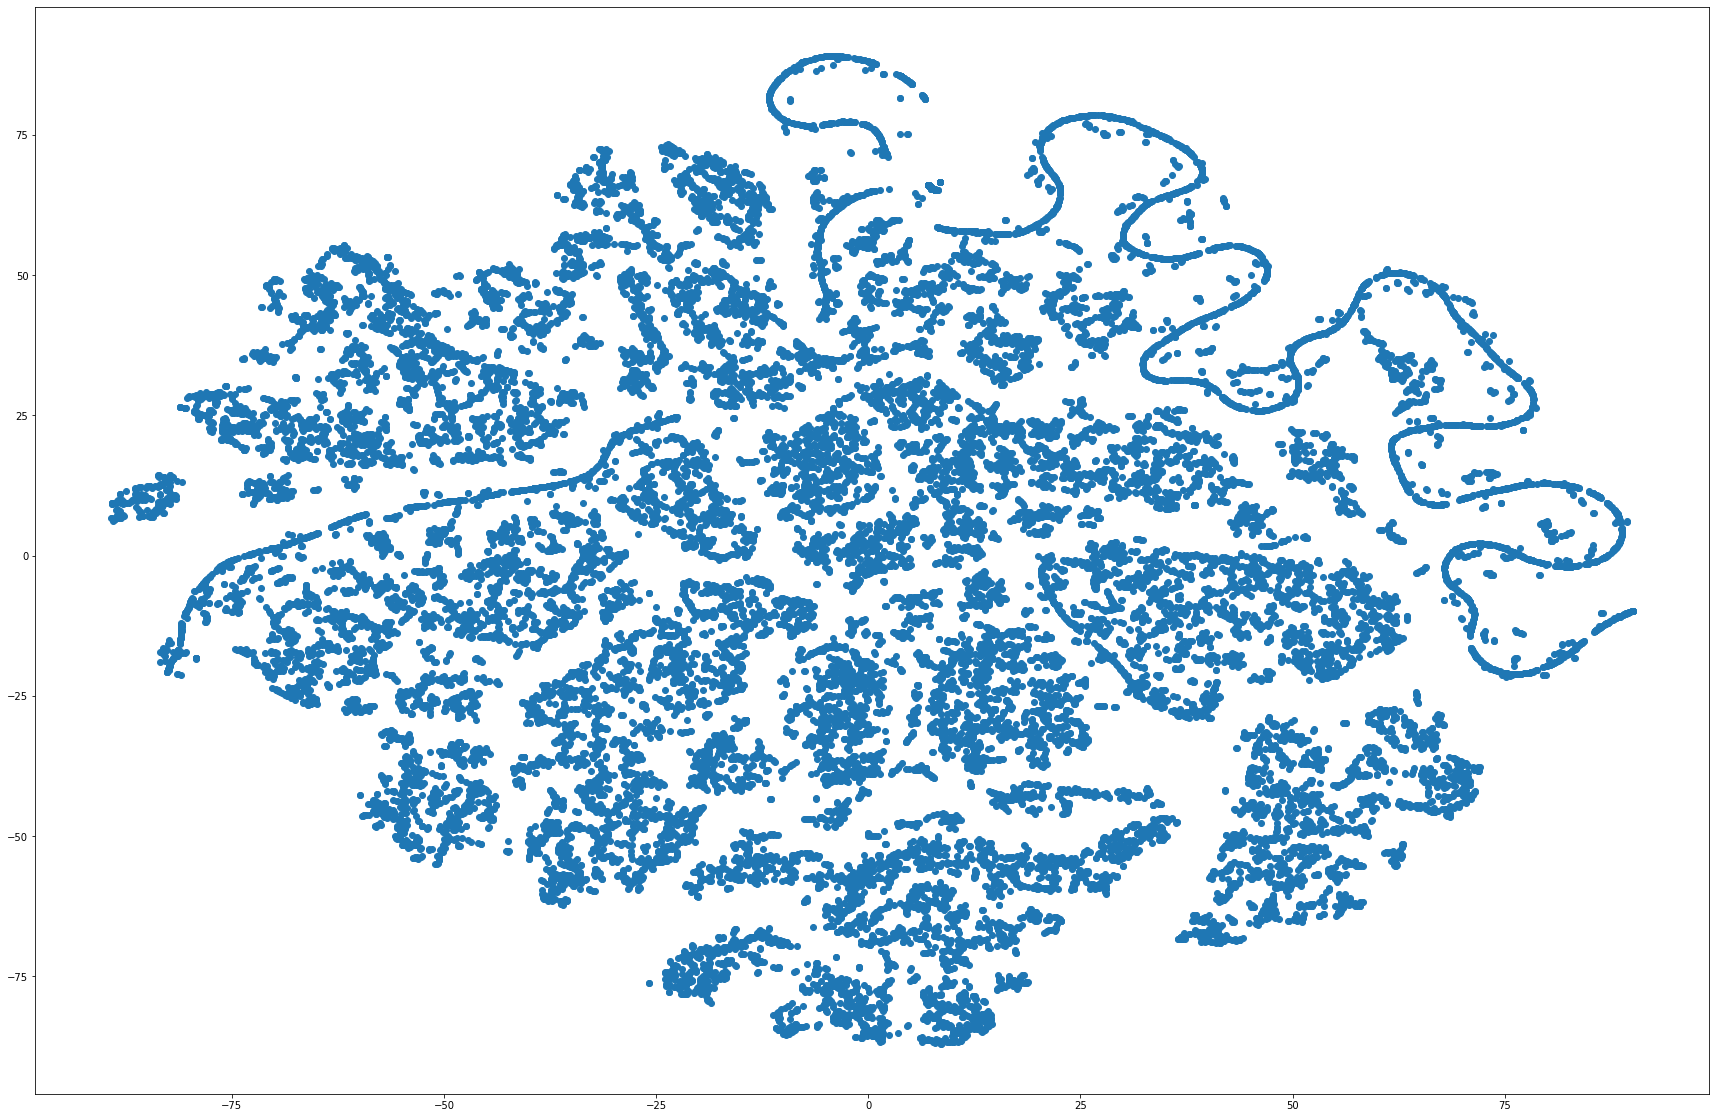

In [32]:
plt.figure(figsize=(30, 20))

plt.scatter(*projection.T)


In [34]:
cuisine_hdbscan_labels_df.columns

Index(['hdbscan_label', 'label_probability'], dtype='object')

In [35]:
cuisine_hdbscan_new_labels_df.columns

Index(['hdbscan_label', 'label_probability'], dtype='object')

In [36]:
all_hdbscan_labels = pd.concat(
    [cuisine_hdbscan_labels_df, cuisine_hdbscan_new_labels_df], axis=0) #.drop(['cuisine_label'], axis=1)
all_hdbscan_labels


,hdbscan_label,label_probability
id,,
54a408a019925f464b3733bc,-1,0.0
54a408a26529d92b2c003631,-1,0.0
54a408a66529d92b2c003638,-1,0.0
54a408a719925f464b3733cc,-1,0.0
54a408c36529d92b2c0036a1,7,1.0
...,...,...
59541a31bff3052847ae2107,-1,0.0
5954233ad52ca90dc28200e7,7,1.0
595424c2109c972493636f83,-1,0.0


In [37]:
color_palette = sns.color_palette('Paired', 12)
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in all_hdbscan_labels['hdbscan_label']]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, all_hdbscan_labels['label_probability'])]


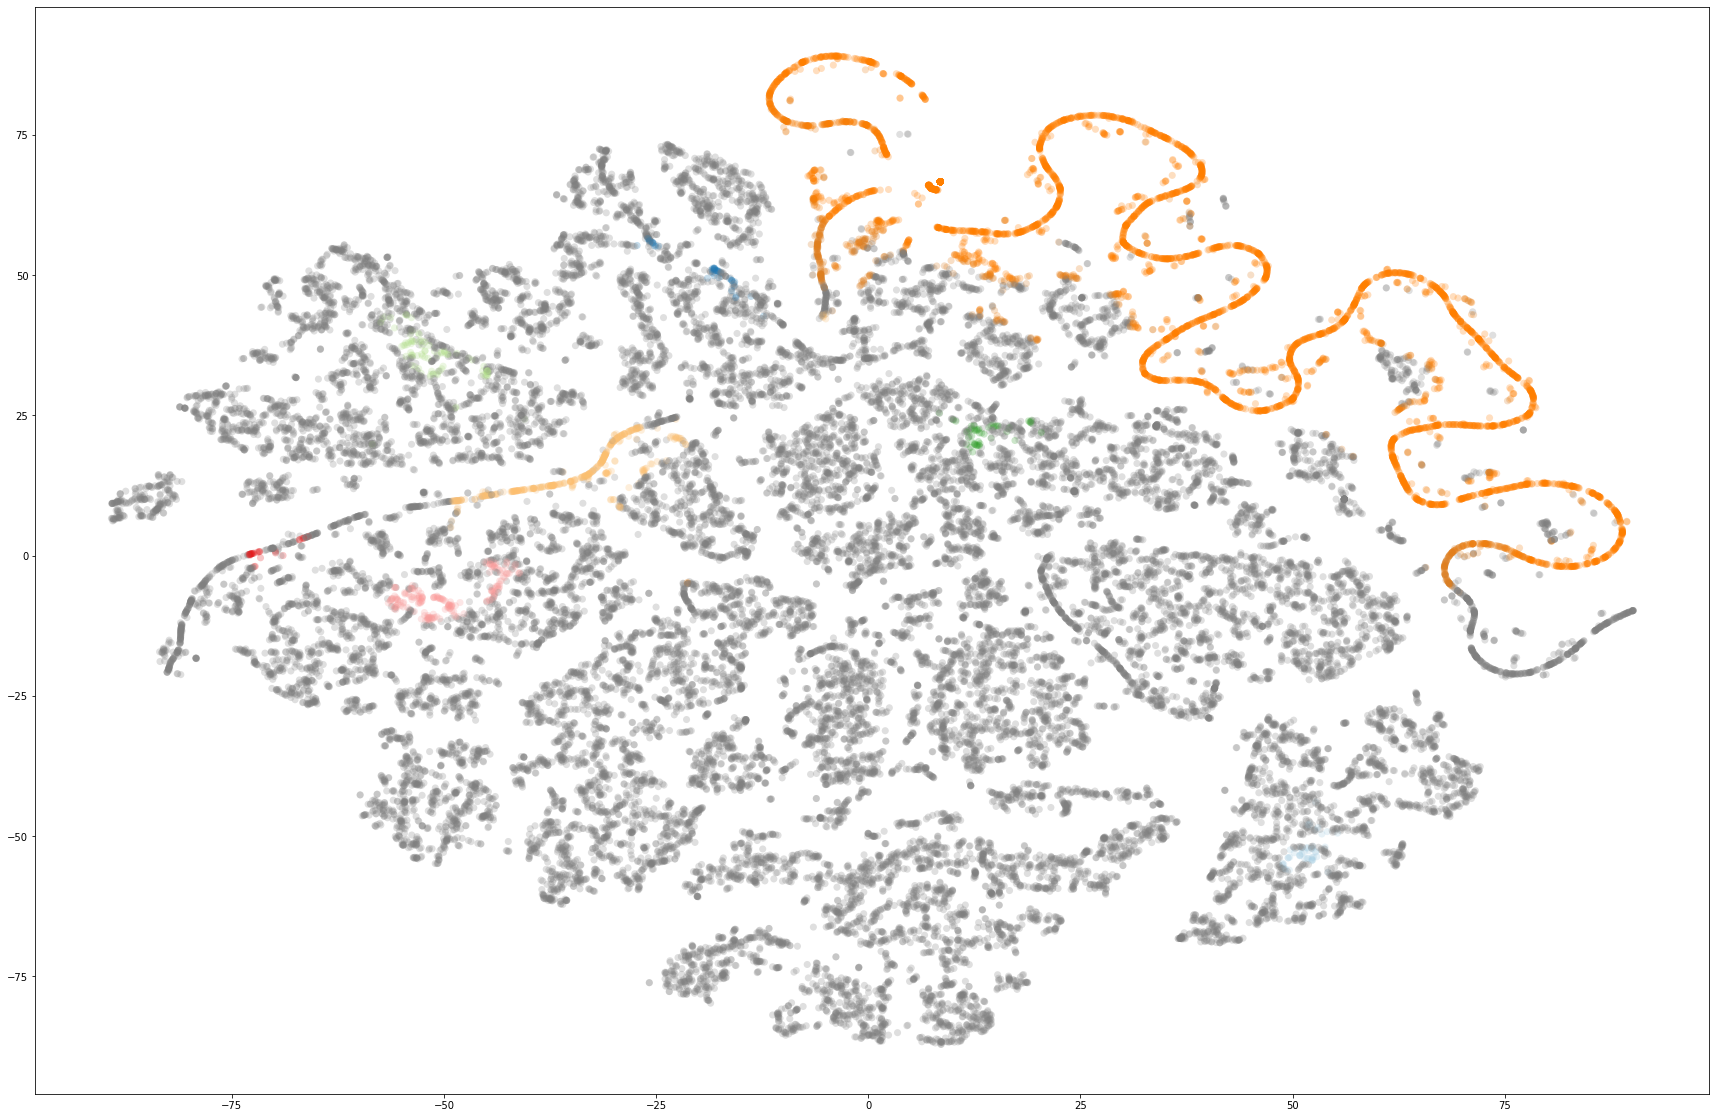

In [39]:
plt.figure(figsize=(30, 20));
plt.scatter(*projection.T, s=50, linewidth=0,
            c=cluster_member_colors, alpha=0.25);


Look at cluster colors and see what group is represented

Looking again, maybe instead of excluding top 2, we exclude max and noise (could leave top 2)

But let's make a helper function anyway

In [49]:
"""
Steps involved for new data:
1. TF-IDF transform
2. NMF transform
3. hdbscan.approximate_predict(hdbscanner, unlabeled_nmf)
4. Attach HDBSCAN labels and probability
    hdbscan_new_labels = list( zip(hdbscan_pred_new_labels[0], hdbscan_pred_new_labels[1]) )
    cuisine_hdbscan_new_labels_df = pd.DataFrame(data=hdbscan_new_labels, columns=['hdbscan_label', 'label_probability'], index=unlabeled_recipes_tfidf_df.index)
    cuisine_hdbscan_new_labels_df
"""


def hdbscan_label_recipe(nmf_transformer, hdbscan_model, new_recipe_df) :

    # new_recipe_df has already been TF-IDF transformed
    
    # new_recipe_tfidf_df = new_recipe_df.drop(
    #     [
    #         'dek',
    #         'hed',
    #         'aggregateRating',
    #         'ingredients',
    #         'prepSteps',
    #         'reviewsCount',
    #         'willMakeAgainPct',
    #         'cuisine_name',
    #         'photo_filename',
    #         'photo_credit',
    #         'author_name',
    #         'date_published',
    #         'recipe_url'
    #     ], axis=1
    # )

    new_recipe_nmf = nmf_transformer.transform(new_recipe_df)

    new_recipe_predicted = hdbscan.approximate_predict(
        hdbscan_model, new_recipe_nmf)

    new_recipe_label = list(
        zip(new_recipe_predicted[0], new_recipe_predicted[1]))
    new_recipe_labeled_df = pd.DataFrame(data=new_recipe_label, columns=[
                                         'hdbscan_label', 'label_probability'], index=new_recipe_df.index)

    return new_recipe_labeled_df


In [51]:
type(unlabeled_recipes_tfidf_df)

pandas.core.frame.DataFrame

In [69]:
test_recipe = unlabeled_recipes_tfidf_df.iloc[200].to_frame(unlabeled_recipes_tfidf_df.iloc[200].name).T

test_recipe

,achiote,acid,addition,adobo,adobo adobo,adobo adobo sauce,adobo sauce,adobo sauce chipotle,african,agave,...,zest pith,zest vegetable,zinfandel,ziti,zucchini,zucchini blossom,zucchini crookneck,zucchini squash,árbol,árbol pepper
54a40b8219925f464b373d23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [64]:
type(test_recipe)

In [67]:
unlabeled_recipes_tfidf_df.iloc[200].name

'54a40b8219925f464b373d23'

In [70]:
test_recipe_labeled = hdbscan_label_recipe(nmf, hdbscanner, test_recipe)
test_recipe_labeled

,hdbscan_label,label_probability
54a40b8219925f464b373d23,-1,0.0
